In [14]:
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from matplotlib import pyplot as plt
from keras.models import load_model
from numpy.random import randint

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
%cd "/content/drive/MyDrive/Strojno_projekt/models"
!pip install import_ipynb
import import_ipynb

/content/drive/MyDrive/Strojno_projekt/models
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
from keras.layers import Layer, InputSpec
from keras import initializers, regularizers, constraints
from keras import backend as K


class InstanceNormalization(Layer):
    """Instance normalization layer.
    Normalize the activations of the previous layer at each step,
    i.e. applies a transformation that maintains the mean activation
    close to 0 and the activation standard deviation close to 1.
    # Arguments
        axis: Integer, the axis that should be normalized
            (typically the features axis).
            For instance, after a `Conv2D` layer with
            `data_format="channels_first"`,
            set `axis=1` in `InstanceNormalization`.
            Setting `axis=None` will normalize all values in each
            instance of the batch.
            Axis 0 is the batch dimension. `axis` cannot be set to 0 to avoid errors.
        epsilon: Small float added to variance to avoid dividing by zero.
        center: If True, add offset of `beta` to normalized tensor.
            If False, `beta` is ignored.
        scale: If True, multiply by `gamma`.
            If False, `gamma` is not used.
            When the next layer is linear (also e.g. `nn.relu`),
            this can be disabled since the scaling
            will be done by the next layer.
        beta_initializer: Initializer for the beta weight.
        gamma_initializer: Initializer for the gamma weight.
        beta_regularizer: Optional regularizer for the beta weight.
        gamma_regularizer: Optional regularizer for the gamma weight.
        beta_constraint: Optional constraint for the beta weight.
        gamma_constraint: Optional constraint for the gamma weight.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a Sequential model.
    # Output shape
        Same shape as input.
    # References
        - [Layer Normalization](https://arxiv.org/abs/1607.06450)
        - [Instance Normalization: The Missing Ingredient for Fast Stylization](
        https://arxiv.org/abs/1607.08022)
    """
    def __init__(self,
                 axis=None,
                 epsilon=1e-3,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)

    def build(self, input_shape):
        ndim = len(input_shape)
        if self.axis == 0:
            raise ValueError('Axis cannot be zero')

        if (self.axis is not None) and (ndim == 2):
            raise ValueError('Cannot specify axis for rank 1 tensor')

        self.input_spec = InputSpec(ndim=ndim)

        if self.axis is None:
            shape = (1,)
        else:
            shape = (input_shape[self.axis],)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
        else:
            self.beta = None
        self.built = True

    def call(self, inputs, training=None):
        input_shape = K.int_shape(inputs)
        reduction_axes = list(range(0, len(input_shape)))

        if self.axis is not None:
            del reduction_axes[self.axis]

        del reduction_axes[0]

        mean = K.mean(inputs, reduction_axes, keepdims=True)
        stddev = K.std(inputs, reduction_axes, keepdims=True) + self.epsilon
        normed = (inputs - mean) / stddev

        broadcast_shape = [1] * len(input_shape)
        if self.axis is not None:
            broadcast_shape[self.axis] = input_shape[self.axis]

        if self.scale:
            broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
            normed = normed * broadcast_gamma
        if self.center:
            broadcast_beta = K.reshape(self.beta, broadcast_shape)
            normed = normed + broadcast_beta
        return normed

    def get_config(self):
        config = {
            'axis': self.axis,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'gamma_constraint': constraints.serialize(self.gamma_constraint)
        }
        base_config = super(InstanceNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [5]:
# load all images in a directory into memory

def load_images(path, size=(256,256)):
	data_list = []

	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		pixels = load_img(path + filename, target_size=size)  # load and resize the image
		pixels = img_to_array(pixels)  # convert to numpy array
		data_list.append(pixels)
  
	return asarray(data_list)


Loaded dataA:  (1096, 256, 256, 3)
Loaded dataB:  (1096, 256, 256, 3)


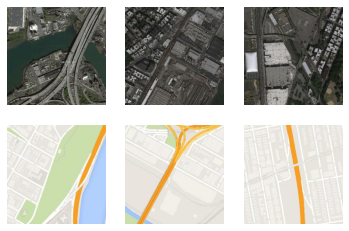

Loaded (1096, 256, 256, 3) (1096, 256, 256, 3)


In [6]:
# dataset path
path = "/content/drive/MyDrive/Strojno_projekt/dataset/maps/"

# load dataset A - satellite images
dataA = load_images(path + "satellites/")
print("Loaded dataA: ", dataA.shape)

# load dataset B - google maps 
dataB = load_images(path + "maps/")
print("Loaded dataB: ", dataB.shape) 

# plot source images
n_samples = 3
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + i)
	plt.axis("off")
	plt.imshow(dataA[i].astype("uint8"))
 
# plot target image
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + n_samples + i)
	plt.axis("off")
	plt.imshow(dataB[i].astype("uint8"))
plt.show()

data = [dataA, dataB]
print("Loaded", data[0].shape, data[1].shape)

In [7]:
def preprocess_data(data):
	X1, X2 = data[0], data[1]
	# [0,255] -> [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
  
	return [X1, X2]

In [ ]:
dataset = preprocess_data(data)

from cycleGAN import generator, discriminator, composite_model, train

image_shape = dataset[0].shape[1:]  # define input shape based on the loaded dataset

g_model_AtoB = generator(image_shape)  # generator: A -> B
g_model_BtoA = generator(image_shape)  # generator: B -> A

d_model_A = discriminator(image_shape)  # discriminator: A -> [real/fake]
d_model_B = discriminator(image_shape)  # discriminator: B -> [real/fake]

c_model_AtoB = composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)  # composite: A -> B -> [real/fake, A]
c_model_BtoA = composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)  # composite: B -> A -> [real/fake, B]

# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs=5)

importing Jupyter notebook from cycleGAN.ipynb
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Streaming output truncated to the last 5000 lines.
Iteration>139, dA[0.120,0.093] dB[0.233,0.091] g[13.508,13.805]
Iteration>140, dA[0.485,0.143] dB[0.164,0.175] g[13.496,12.167]
Iteration>141, dA[0.135,0.195] dB[0.108,0.258] g[11.815,10.918]
Iteration>142, dA[0.291,0.180] dB[0.097,0.088] g[13.513,12.171]
Iteration>143, dA[0.115,0.096] dB[0.071,0.010] g[15.314,14.495]
Iteration>144, dA[0.219,0.153] dB[0.099,0.050] g[12.945,11.615]
Iteration>145, dA[0.162,0.043] dB[0.101,0.057] g[13.304,13.347]
Iteration>146, dA[0.143,0.094] dB[0.061,0.047] g[14.099,12.887]
Iteration>147, dA[0.108,0.119] dB[0.127,0.036] g[11.851,10.472]
Iteration>148, dA[0.083,0.188] dB[0.045,0.054] g[13.242,11.758]
Iteration>149, dA[0.143,0.059] dB[0.145,0.165] g[11.861,11.394]
Iteration>150, dA[0.035,0.021] dB[0.064,0.086] g[15.405,14.562]
Iteration>151, dA[0.120,0.069] dB[0.057,0.123] g[12.684,11.470]
Iteration>152, dA[0.115,0.064] dB[0.092,0.136] g[13.769,12.560]
Iteration>153, dA[0.054,0.130] dB[0.072,0.029] g[15.2

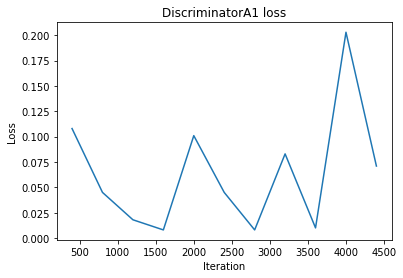

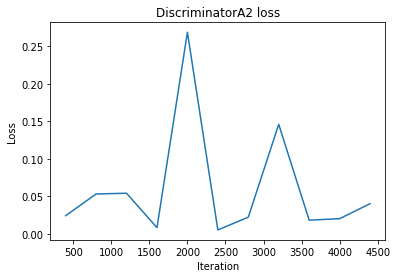

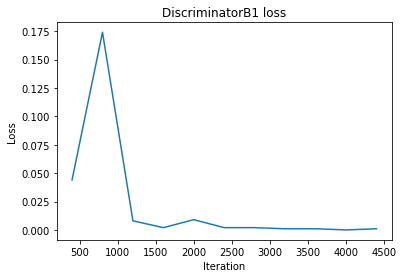

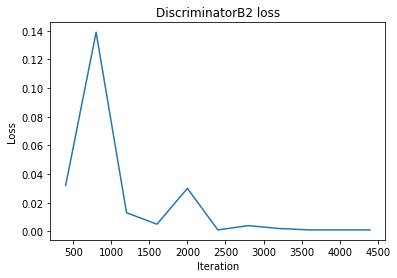

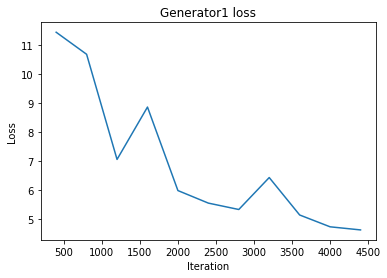

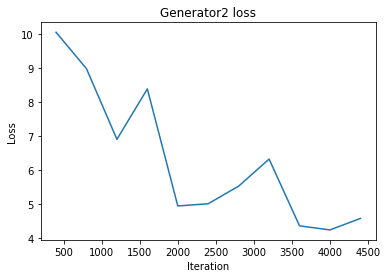

In [7]:
# colab disconnected at 5118, so adding losses manually - starting from 400. iteration, step:400
import matplotlib.pyplot as plt

dA1_losses = [0.108,0.045,0.018,0.008,0.101,0.045,0.008,0.083,0.010,0.203,0.071] 
dA2_losses = [0.024,0.053,0.054,0.008,0.269,0.005,0.022,0.146,0.018,0.020,0.040]
dB1_losses = [0.044,0.174,0.008,0.002,0.009,0.002,0.002,0.001,0.001,0.000,0.001]
dB2_losses = [0.032,0.139,0.013,0.005,0.030,0.001,0.004,0.002,0.001,0.001,0.001]
g1_losses = [11.433,10.674,7.054,8.857,5.982,5.550,5.330,6.430,5.141,4.734,4.627]
g2_losses = [10.055,8.985,6.910,8.391,4.953,5.019,5.536,6.330,4.369,4.250,4.587]
iterations = [i*400 for i in range(1,12)]

plt.plot(iterations, dA1_losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("DiscriminatorA1 loss")
plt.show()

plt.plot(iterations, dA2_losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("DiscriminatorA2 loss")
plt.show()

plt.plot(iterations, dB1_losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("DiscriminatorB1 loss")
plt.show()

plt.plot(iterations, dB2_losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("DiscriminatorB2 loss")
plt.show()

plt.plot(iterations, g1_losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Generator1 loss")
plt.show()

plt.plot(iterations, g2_losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Generator2 loss")
plt.show()

In [8]:
# select a random sample of images from the dataset

def select_sample(dataset, n_samples):
	ix = randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]
  
	return X

In [9]:
# plot the image, its translation, and the reconstruction

def show_plot(imagesX, imagesY1, imagesY2):
	images = vstack((imagesX, imagesY1, imagesY2))
	titles = ["Real", "Generated", "Reconstructed"]
	
  # [-1,1] -> [0,1]
	images = (images + 1) / 2.0
	
  # plot images row by row
	for i in range(len(images)):
		plt.subplot(1, len(images), 1 + i)
		plt.axis("off")
		plt.imshow(images[i])
		plt.title(titles[i])
	plt.show()

In [10]:
from numpy import expand_dims

# load an image
def load_image(filename):
	pixels = load_img(filename)
	# convert to numpy array
	pixels = img_to_array(pixels)
	# [0,255] -> [-1,1]
	pixels = (pixels - 127.5) / 127.5
	# reshape to 1 sample
	pixels = expand_dims(pixels, 0)
	return pixels

Loaded (1, 256, 256, 3) (1, 256, 256, 3)


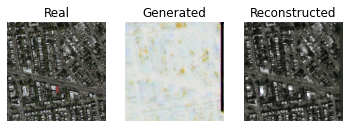

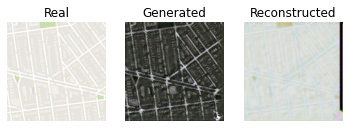

In [17]:
# load the models
cust = {"InstanceNormalization": InstanceNormalization}
model_AtoB = load_model("/content/drive/MyDrive/Strojno_projekt/models/cycleGAN_saved_models/g_model_AtoB_004384.h5", cust)
model_BtoA = load_model("/content/drive/MyDrive/Strojno_projekt/models/cycleGAN_saved_models/g_model_BtoA_004384.h5", cust)

src_image = load_image("/content/drive/MyDrive/Strojno_projekt/dataset/inputs_cycleGAN/1a.jpg")
target_image = load_image("/content/drive/MyDrive/Strojno_projekt/dataset/inputs_cycleGAN/1b.jpg")
print("Loaded", src_image.shape, target_image.shape)

# plot A->B->A (satellite to map to satellite)
B_generated  = model_AtoB.predict(src_image)
A_reconstructed = model_BtoA.predict(B_generated)
show_plot(src_image, B_generated, A_reconstructed)

# plot B->A->B (map to satellite to map)
A_generated  = model_BtoA.predict(target_image)
B_reconstructed = model_AtoB.predict(A_generated)
show_plot(target_image, A_generated, B_reconstructed)